In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import ccxt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.get_data import get_historical_from_db
import ta

In [2]:
pair = "BTC/USDT"
tf = "1d"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)

training_set = df.copy().loc[:"2020"]
test_set = df.copy().loc["2021":]
learn_period = 7

training_set

,open,high,low,close,volume
date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2020-12-27,26493.40,28422.00,25700.00,26281.66,148455.586214
2020-12-28,26281.54,27500.00,26101.00,27079.41,79721.742496
2020-12-29,27079.42,27410.00,25880.00,27385.00,69411.592606


In [3]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set["close"].values.reshape(-1, 1))

X_train = []
y_train = []

for i in range(learn_period, len(training_set)):
    X_train.append(training_set_scaled[i-learn_period:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train[0][0:2]

array([[0.04259089],
       [0.03572426]])

In [4]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

2022-07-04 20:04:22.986129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
39/39 [==============================] - 9s 18ms/step - loss: 0.0204
Epoch 2/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 3/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 4/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0020
Epoch 5/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0021
Epoch 6/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0023
Epoch 7/50
39/39 [==============================] - 1s 27ms/step - loss: 0.0018
Epoch 8/50
39/39 [==============================] - 1s 18ms/step - loss: 0.0017
Epoch 9/50
39/39 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 10/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 11/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 12/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 13/50
39/39 [==================

In [5]:
real_stock_price = test_set.iloc[:, 1:2].values

dataset_total = pd.concat((training_set['close'], test_set['close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - learn_period:].values
inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(learn_period, len(test_set) + learn_period):
    X_test.append(inputs[i-learn_period:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

18/18 [==============================] - 2s 6ms/step


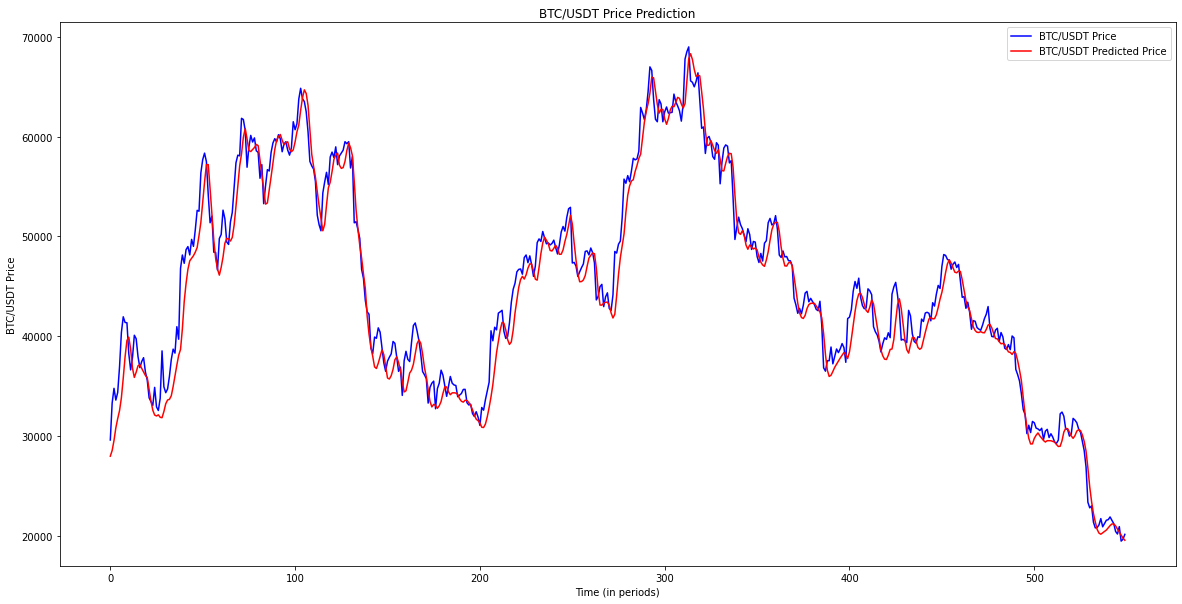

In [6]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'blue', label = pair + ' Price')
plt.plot(predicted_stock_price, color = 'red', label = pair + ' Predicted Price')
plt.title(pair +' Price Prediction')
plt.xlabel('Time (in periods)')
plt.ylabel(pair + ' Price')
plt.legend()
plt.show()

In [7]:
df["predicted"] = 0
df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()
df["diff_close"] = df["close"].diff()
df["diff_predicted"] = df["predicted"].diff()
df["next_predicted"] = df["predicted"].shift(-1)
df["next_close"] = df["close"].shift(-1)
df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
df["diff_close_next"] = df["next_close"] - df["close"]
df["mean_evol_3"] = df["close"].shift(-3).rolling(3).mean() - df["close"]
df["mean_evol_5"] = df["close"].shift(-5).rolling(5).mean() - df["close"]
df["mean_evol_10"] = df["close"].shift(-10).rolling(10).mean() - df["close"]
df["mean_evol_20"] = df["close"].shift(-20).rolling(20).mean() - df["close"]
df

/Users/gauthiermarre/Desktop/Crypto Robot/backtest_tools/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,open,high,low,close,volume,predicted,diff_close,diff_predicted,next_predicted,next_close,diff_predicted_next,diff_close_next,mean_evol_3,mean_evol_5,mean_evol_10,mean_evol_20
date,,,,,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,0.000000,NaN,NaN,0.000000,4108.37,0.000000,-176.71,NaN,NaN,NaN,NaN
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,0.000000,-176.71,0.000000,0.000000,4139.98,0.000000,31.61,NaN,NaN,NaN,NaN
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,0.000000,31.61,0.000000,0.000000,4086.29,0.000000,-53.69,-92.550000,NaN,NaN,NaN
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,0.000000,-53.69,0.000000,0.000000,4016.00,0.000000,-70.29,-29.620000,NaN,NaN,NaN
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,0.000000,-70.29,0.000000,0.000000,4040.00,0.000000,24.00,140.673333,201.628,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,20123.00,20179.08,18626.00,19942.21,93846.648060,20672.921875,-180.80,-318.679688,20386.001953,19279.80,-286.919922,-662.41,-659.396667,NaN,NaN,NaN
2022-07-01,19942.21,20918.35,18975.00,19279.80,111844.594940,20386.001953,-662.41,-286.919922,20063.349609,19252.81,-322.652344,-26.99,213.180000,NaN,NaN,NaN
2022-07-02,19279.80,19467.39,18977.01,19252.81,46180.302100,20063.349609,-26.99,-322.652344,19769.314453,19315.83,-294.035156,63.02,NaN,NaN,NaN,NaN


In [8]:
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] > 0)]))
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] < 0)]))
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_20"].mean())

477
373
-------------
475
456
-------------
9.392458823529342
3.4570906949360274
-5.126904368359011
12.462418052256467
10.693026978417283
-------------
8.39778732545656
29.740459275207318
54.65983818770232
84.04546529284177
180.60483901098905


In [9]:
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] > 0)]))
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] < 0)]))
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted"] > 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted"] < 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_20"].mean())

123
147
-------------
130
150
-------------
30.761666666666564
50.052975308644264
40.054637037036905
-19.798816479400966
-281.8510113636363
-------------
-63.53777777777768
-131.88243080625423
-169.63053818181805
-248.09364468864428
-298.1444135338342


In [19]:
def merge_dico(dict1,dict2) : 
    final_dict = dict1.copy()
    final_dict.update(dict2)
    return final_dict

In [20]:
class lstm_strat():
    def __init__(
        self,
        df,
        use_short=True,
        strat=0,
    ):
        self.df = df
        self.use_short = use_short
        self.strat = strat
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume', "predicted"]), inplace=True)
        
        # -- Populate indicators --
        df["diff_close"] = df["close"].diff()
        df["diff_predicted"] = df["predicted"].diff()
        df["next_predicted"] = df["predicted"].shift(-1)
        df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
        
        # -- Log --
        if(show_log):
            print(df)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self, show_log=False): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.strat == 0:
            # -- Populate open long market --
            df.loc[
                (df['diff_predicted'] > 0)
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['diff_predicted'] < 0) 
                , "close_long_market"
            ] = True
            
            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['diff_predicted'] < 0) 
                    , "open_short_market"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['diff_predicted'] > 0) 
                    , "close_short_market"
                ] = True

        elif self.strat == 1:
            # -- Populate open long market --
            df.loc[
                (df['diff_predicted_next'] > df['diff_close'])
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['diff_close'] > df['diff_predicted_next']) 
                , "close_long_market"
            ] = True
            
            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['diff_close'] > df['diff_predicted_next']) 
                    , "open_short_market"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['diff_predicted_next'] > df['diff_close']) 
                    , "close_short_market"
                ] = True
            
        
        # -- Log --
        if(show_log):
            print("Open LONG length :",len(df.loc[df["open_long_market"]==True]))
            print("Close LONG length :",len(df.loc[df["close_long_market"]==True]))
            print("Open SHORT length :",len(df.loc[df["open_short_market"]==True]))
            print("Close SHORT length :",len(df.loc[df["close_short_market"]==True]))
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        # print("tp",take_profit_pct,"sl",stop_loss_pct)
        
        for index, row in dt.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":
                        
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # Open long market
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return merge_dico(get_metrics(df_trades, df_days),{
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }) 
        else:
            return True    
        

Period: [2021-01-01 00:00:00] -> [2022-07-04 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 1068.76 $
Performance vs US dollar: 6.88 %
Sharpe Ratio: 0.34
Worst Drawdown T|D: -46.31% | -50.05%
Buy and hold performance: -32.12 %
Performance vs buy and hold: 57.45 %
Total trades on the period: 59
Global Win rate: 45.76 %
Average Profit: 0.42 %

Best trades: +44.81 % the 2021-01-30 00:00:00 -> 2021-02-24 00:00:00
Worst trades: -11.95 % the 2021-05-26 00:00:00 -> 2021-05-29 00:00:00


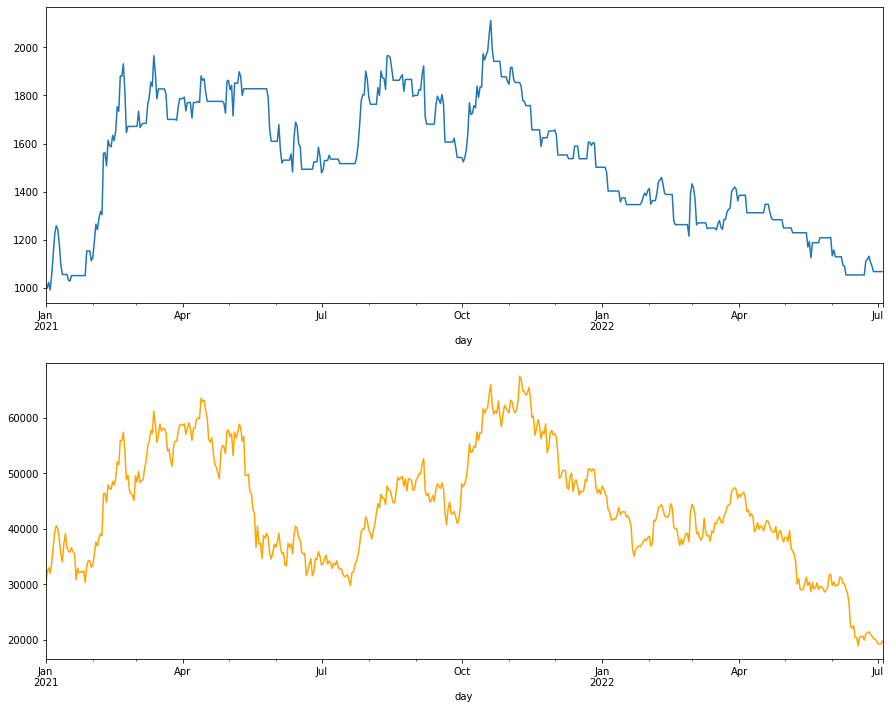

In [23]:
dt = df.copy().loc["2021":]

strat = lstm_strat(
    df = dt,
    use_short=False,
    strat=0,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=False)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

Open LONG length : 276
Close LONG length : 272
Open SHORT length : 272
Close SHORT length : 276
Period: [2021-01-01 00:00:00] -> [2022-07-04 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 1083.0 $
Performance vs US dollar: 8.3 %
Sharpe Ratio: 0.4
Worst Drawdown T|D: -46.02% | -46.13%
Buy and hold performance: -32.12 %
Performance vs buy and hold: 59.55 %
Total trades on the period: 207
Global Win rate: 63.29 %
Average Profit: 0.21 %

Best trades: +19.38 % the 2021-02-07 00:00:00 -> 2021-02-08 00:00:00
Worst trades: -26.83 % the 2022-06-08 00:00:00 -> 2022-06-14 00:00:00


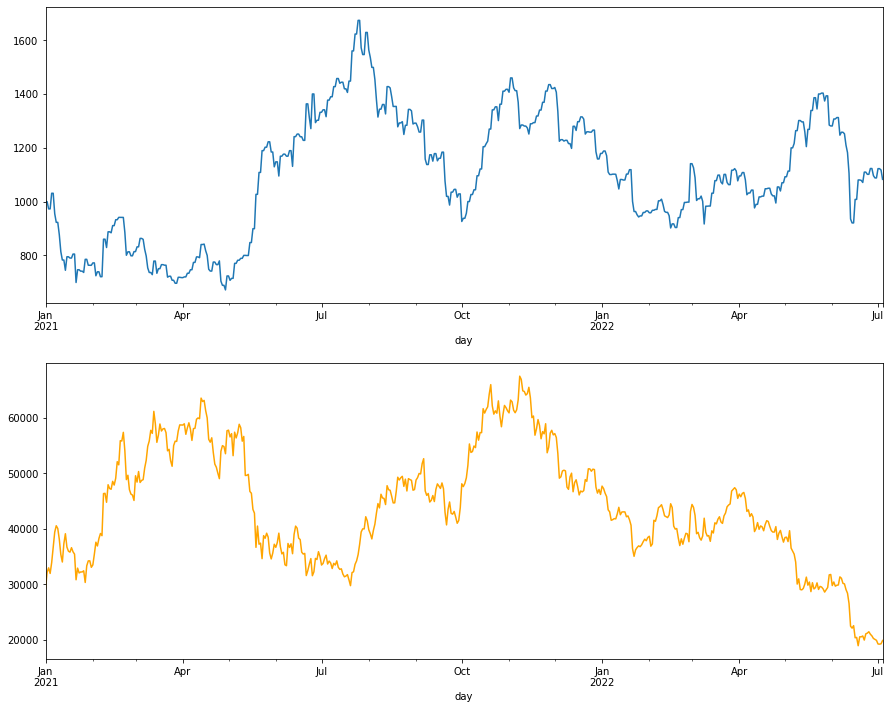

In [24]:
dt = df.copy().loc["2021":]

strat = lstm_strat(
    df = dt,
    use_short=True,
    strat=1,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])